<a href="https://colab.research.google.com/github/dsercam/mold-inspired/blob/main/Mold_Network_W7_wip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from shapely.geometry import LineString, Polygon, Point
from IPython.display import HTML
import matplotlib.animation as animation
%matplotlib inline

In [2]:
!apt install gdal-bin
!gdalinfo --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.6.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
GDAL 3.6.4, released 2023/04/17


In [3]:
# CV: GDAL to handle elevation maps.
from osgeo import gdal
elevation_map = gdal.Open('Hidalgo_r15m.tif').ReadAsArray()
print('Elevation map size: ', elevation_map.shape) #map size in pixels

Elevation map size:  (12965, 13497)


In [4]:
# Map has a signifcant size, lets get a section of it for demo purposes
elevation_map =  elevation_map[3160:5300,4000:8600]
workspace_latitude = elevation_map.shape[0] # Dimensions of the map section to be used
workspace_longitude = elevation_map.shape[1]

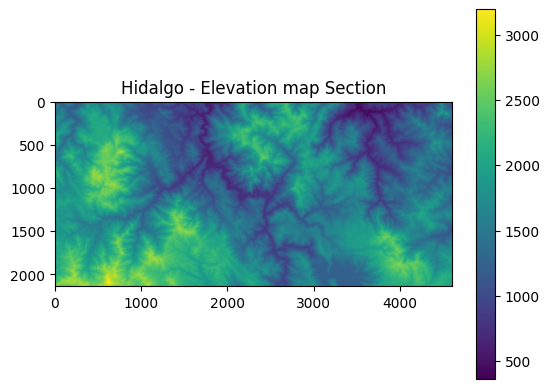

In [5]:
#Render map
plt.figure()
plt.imshow(elevation_map)
plt.title('Hidalgo - Elevation map Section')
plt.colorbar()
plt.show()
#Blue areas - lower elevation
#Yellow areas - higher elevation

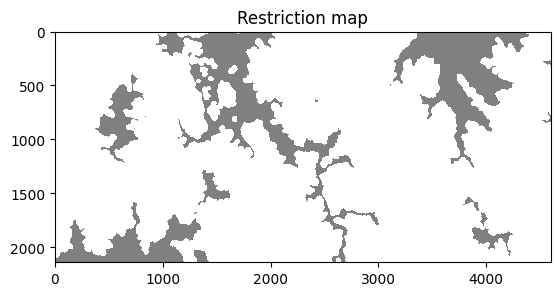

Final map size:  (2140, 4600)


In [6]:
# Libraries for image processing
from skimage.morphology import binary_dilation
from skimage import morphology
from skimage.filters import gaussian
import matplotlib.colors

# Define a color map for allowed and restricted areas.
# white will be used as allowed areas
# gray represents restricted areas
cmap_elevation_mask = matplotlib.colors.ListedColormap(['white', 'gray'])

# Define a #goldilocks zone" between 1200 and 2300 m
max_altitude = 2300
min_altitude = 1200

boolean_map = gaussian(elevation_map, sigma=10)
boolean_map = (elevation_map < max_altitude)&(elevation_map > min_altitude) # Get outline of terrain within our goldilocks zone
boolean_map = binary_dilation(boolean_map, morphology.disk(radius=10))
boolean_map = 1 - binary_dilation(boolean_map, morphology.disk(radius=10))

# Render restricted areas map
plt.figure()
plt.imshow(boolean_map, cmap=cmap_elevation_mask)
plt.title('Restriction map')
plt.show()

print('Final map size: ', boolean_map.shape)


### IDEA:
- Use an image derivative to calculate the slope value of a given edge, which could be used as a boosting score or handicap between nodes.

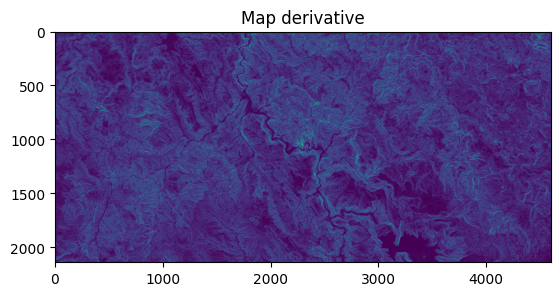

In [231]:
# Generate a map derivative
from skimage.filters import laplace
from skimage.filters import sobel
dev_map = sobel(elevation_map/np.sum(elevation_map))
dev_map = dev_map/(np.max(dev_map)-np.min(dev_map))

plt.figure()
plt.imshow(dev_map)
plt.title('Map derivative')
plt.show()

In [77]:
# CV función que verifica si un punto esta en una area permitida
# tomen en cuenta que en las imagenes el eje x es el vertical y el y es el horizontal

from skimage.draw import line

# Function contains(boolean_map, point)
# Given a binary map - determine if a specified point falls within a restricted area.
def contains(boolean_map, point):
  return boolean_map[int(point.x), int(point.y)] #returns true if the point exists in the boolean map (gray area)

#Function line_collision(boolean_map, start, end)
# Function help us determine if an edge - defined as a line between two points, crosses a restricted area
def line_collision(boolean_map, start, end):

  s = Point(start[0], start[1]) #start point
  e = Point(end[0], end[1]) # end point

  # First determine if either the start or end points are in a restricted area, if any of them is, return TRUE immediately
  if contains(boolean_map, s) or contains(boolean_map, e): return True

  # if endpoints are clear, lets determine if any point in the edge between them falls into a restricted area
  rr, cc = line(int(s.x), int(s.y), int(e.x), int(e.y))
  pixels = boolean_map[rr, cc] # pixels in the line matching against pixels on the restricted areas - if any, return true
  if True in pixels:
    return True
  return False



In [ ]:
# Function contains(boolean_map, point)
# Given a binary map - determine if a specified point falls within a restricted area.
def contains_point(boolean_map, point):
  return boolean_map[int(point[0]),int(point[1])] #returns true if the point exists in the boolean map (gray area)

#Function line_collision_points(boolean_map, start, end)
# Function help us determine if an edge - defined as a line between two points, crosses a restricted area
def line_collision_points(boolean_map, start_node, end_node):

  s = node_positions[start_node] #start point
  e = node_positions[end_node] # end point

  # First determine if either the start or end points are in a restricted area, if any of them is, return TRUE immediately
  if contains_point(boolean_map, s) or contains_point(boolean_map, e): return True

  # if endpoints are clear, lets determine if any point in the edge between them falls into a restricted area
  rr, cc = line(int(s[0]),int(s[1]), int(e[0]),int(e[1]))
  pixels = boolean_map[rr, cc] # pixels in the line matching against pixels on the restricted areas - if any, return true
  if True in pixels:
    return True
  return False

### Idea: define an elevation score using the derivative map

In [233]:
def score_elevation(dev_map, start, end):

  s = Point(start[0], start[1])
  e = Point(end[0], end[1])

  rr, cc = line(int(s.x), int(s.y), int(e.x), int(e.y))
  pixels = dev_map[rr, cc]
  return np.max(pixels)

In [108]:
# Define the qty of nodes to be traced
num_nodos = 100

# Generate positions for each node within the workspace - our map section
node_positions = {}
for node_id in range(num_nodos):
    while True:
        x, y = np.random.uniform(0, workspace_latitude), np.random.uniform(0, workspace_longitude)
        point = Point(x, y)
        # Validate the point does not fall into a restricted area
        #if cleared, assign coordinates to the point, a new set of values will be considered otherwise until condition is fulfilled
        if not (contains(boolean_map, point)):
            node_positions[node_id] = (x, y)
            break  # Exit assignment on valid position

# Create empty graph.
G = nx.Graph()
G.add_nodes_from(node_positions.keys())

# Connect each node to a given number of n closest nodes
k = 20  #Number of n closest nodes to connect

for node in G.nodes():
    # Calculate distances to other nodes
    distancias = []
    for otro_nodo in G.nodes():
        if otro_nodo != node:
            distancia = np.hypot(node_positions[node][0] - node_positions[otro_nodo][0],
                                 node_positions[node][1] - node_positions[otro_nodo][1])
            distancias.append((otro_nodo, distancia))
    # Order by distance and connect to closest nodes
    distancias.sort(key=lambda x: x[1])
    vecinos = [n for n, d in distancias[:k]]
    for vecino in vecinos:
        # Generate an edge if the line between two given nodes does not cross a restricted area
        start = node_positions[node]
        end = node_positions[vecino]
        if not(line_collision(boolean_map, start, end)):
            if not G.has_edge(node, vecino):
                G.add_edge(node, vecino)

In [109]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99))

In [110]:
G.edges()

EdgeView([(0, 9), (0, 85), (0, 74), (0, 36), (0, 3), (0, 60), (0, 70), (0, 97), (0, 1), (0, 5), (0, 31), (0, 47), (0, 73), (0, 40), (0, 72), (1, 97), (1, 85), (1, 73), (1, 22), (1, 9), (1, 19), (1, 31), (1, 69), (1, 93), (2, 20), (2, 35), (2, 49), (2, 40), (2, 78), (2, 83), (2, 94), (2, 72), (2, 8), (2, 99), (2, 5), (2, 38), (2, 60), (2, 86), (2, 47), (3, 70), (3, 60), (3, 74), (3, 47), (3, 5), (3, 36), (3, 87), (3, 9), (3, 85), (3, 72), (3, 40), (3, 78), (3, 97), (3, 35), (4, 56), (4, 80), (4, 98), (4, 79), (4, 82), (4, 27), (5, 60), (5, 78), (5, 72), (5, 40), (5, 47), (5, 85), (5, 35), (5, 70), (5, 20), (5, 74), (5, 36), (5, 22), (5, 9), (5, 87), (6, 13), (6, 52), (6, 44), (6, 7), (6, 31), (6, 43), (6, 64), (6, 21), (6, 26), (6, 62), (6, 58), (6, 37), (6, 45), (7, 44), (7, 21), (7, 13), (7, 52), (7, 26), (7, 37), (7, 62), (7, 58), (7, 43), (7, 64), (8, 99), (8, 94), (8, 83), (8, 86), (8, 38), (8, 35), (8, 20), (8, 89), (8, 42), (8, 78), (8, 40), (8, 72), (9, 36), (9, 74), (9, 70), (9

In [111]:
# Initialize longitudes and conductivities
D = {}
L = {}
for edge in G.edges():
    # Calculate longitude using euclidean distance
    pos_i = node_positions[edge[0]]
    pos_j = node_positions[edge[1]]

    # Initial conductivity as 1.0
    # One of the ideas is to boost or set a handicap to a node based on certain attributes ' WIP
    # D[edge] = score_elevation(dev_map, pos_i, pos_j)

    length = np.hypot(pos_i[0] - pos_j[0], pos_i[1] - pos_j[1])
    D[edge] = 1.0
    L[edge] = length

# Assing conductivity and longitude to the edges
nx.set_edge_attributes(G, D, 'conductivity')
nx.set_edge_attributes(G, L, 'length')

In [112]:
def adjust_pressures(G, source_node, sink_node, I0):
    # ... (código igual al anterior)
    # Sin cambios significativos
    n_nodes = G.number_of_nodes()
    node_list = list(G.nodes())
    node_indices = {node: idx for idx, node in enumerate(node_list)}

    # Vector de fuentes y sumideros
    S = np.zeros(n_nodes)
    S[node_indices[source_node]] = I0
    S[node_indices[sink_node]] = -I0

    # Matriz de conductancias
    C = np.zeros((n_nodes, n_nodes))

    for edge in G.edges():
        i = node_indices[edge[0]]
        j = node_indices[edge[1]]
        D_ij = G.edges[edge]['conductivity']
        L_ij = G.edges[edge]['length']
        C_ij = D_ij / L_ij
        C[i, j] = -C_ij
        C[j, i] = -C_ij
        C[i, i] += C_ij
        C[j, j] += C_ij

    # Aplicar condición de frontera (fijar la presión en el nodo sumidero a cero)
    sink_idx = node_indices[sink_node]
    C_reduced = np.delete(np.delete(C, sink_idx, axis=0), sink_idx, axis=1)
    S_reduced = np.delete(S, sink_idx)

    # Resolver el sistema lineal para las presiones
    try:
        p_reduced = np.linalg.solve(C_reduced, S_reduced)
    except np.linalg.LinAlgError:
        # Si la matriz no es invertible, retornar presiones cero
        p_reduced = np.zeros(n_nodes - 1)

    # Insertar la presión conocida en el nodo sumidero
    p = np.insert(p_reduced, sink_idx, 0)

    # Calcular los flujos en cada borde
    Q = {}
    for edge in G.edges():
        i = node_indices[edge[0]]
        j = node_indices[edge[1]]
        D_ij = G.edges[edge]['conductivity']
        L_ij = G.edges[edge]['length']
        Q_ij = D_ij * (p[i] - p[j]) / L_ij
        Q[edge] = Q_ij

    return p, Q

def update_conductivities(G, Q, delta_t, g):
    """
    Actualiza las conductividades de los bordes en función del flujo.
    """
    edges_to_remove = []
    for edge in G.edges():
        # Verificar si el borde cruza un obstáculo
        print("update_conductivities_for")
        start = node_positions[edge[0]]
        end = node_positions[edge[1]]
        if (line_collision(boolean_map, end, start)):
            print("Will remove edge")
            edges_to_remove.append(edge)
        else:
            D_ij = G.edges[edge]['conductivity']
            Q_ij = abs(Q[edge])
            # Función de respuesta sigmoidea
            f_Q = (Q_ij ** g) / (1.0 + Q_ij ** g)
            dD_dt = f_Q - D_ij
            D_new = D_ij + delta_t * dD_dt
            print("New conductivity" + str(D_new))
            # Asegurar que las conductividades sean positivas
            G.edges[edge]['conductivity'] = max(D_new, 1e-6)  # Evitar conductividades cero o negativas
    # Eliminar los bordes que cruzan obstáculos
    G.remove_edges_from(edges_to_remove)

Streaming output truncated to the last 5000 lines.
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New conductivity0.1853020188851841
update_conductivities_for
New cond

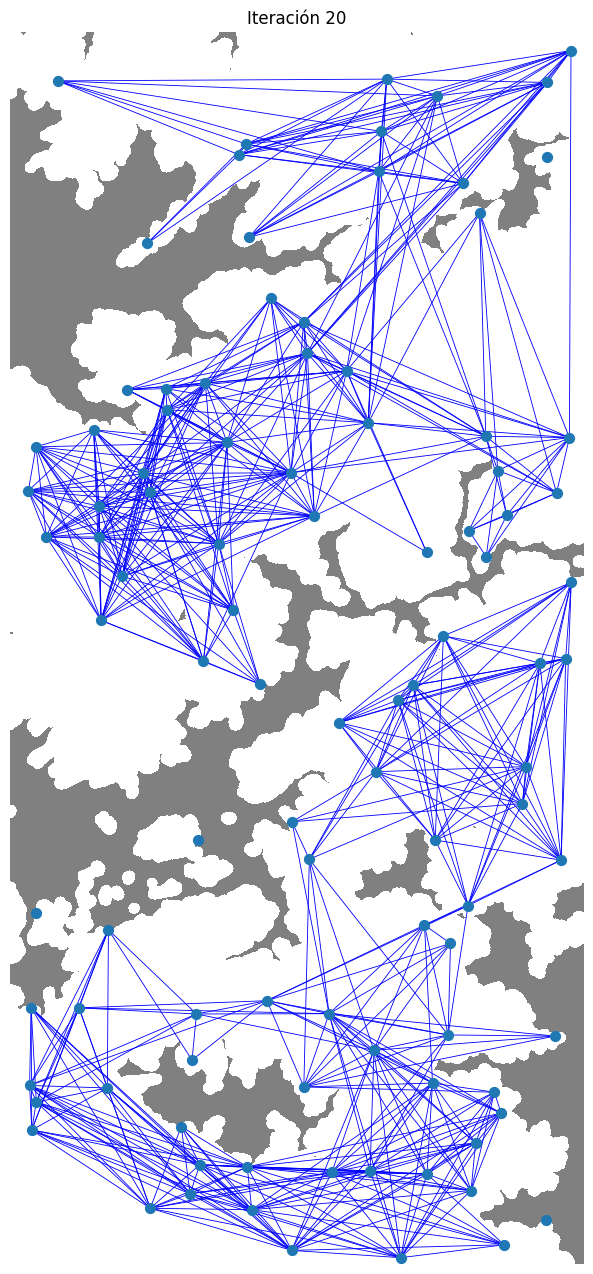

Streaming output truncated to the last 5000 lines.
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
update_conductivities_for
New conductivity0.022528399544939168
upda

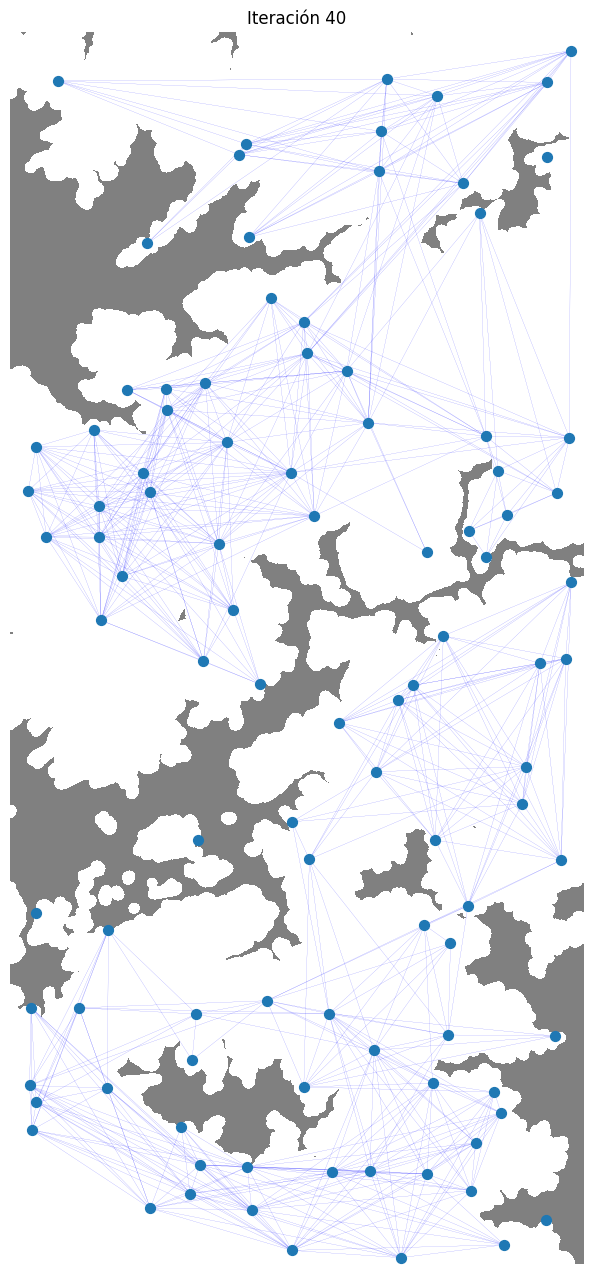

Streaming output truncated to the last 5000 lines.
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
update_conductivities_for
New conductivity0.002738927449953408
upda

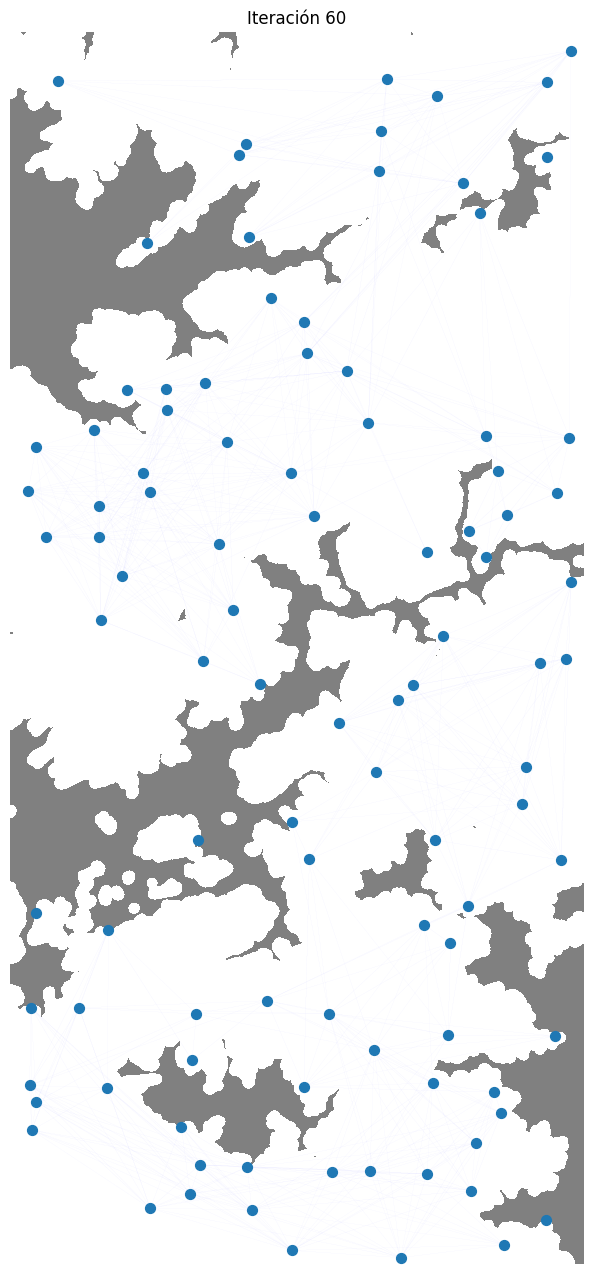

Streaming output truncated to the last 5000 lines.
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductivity0.00033298963653161415
update_conductivities_for
New conductiv

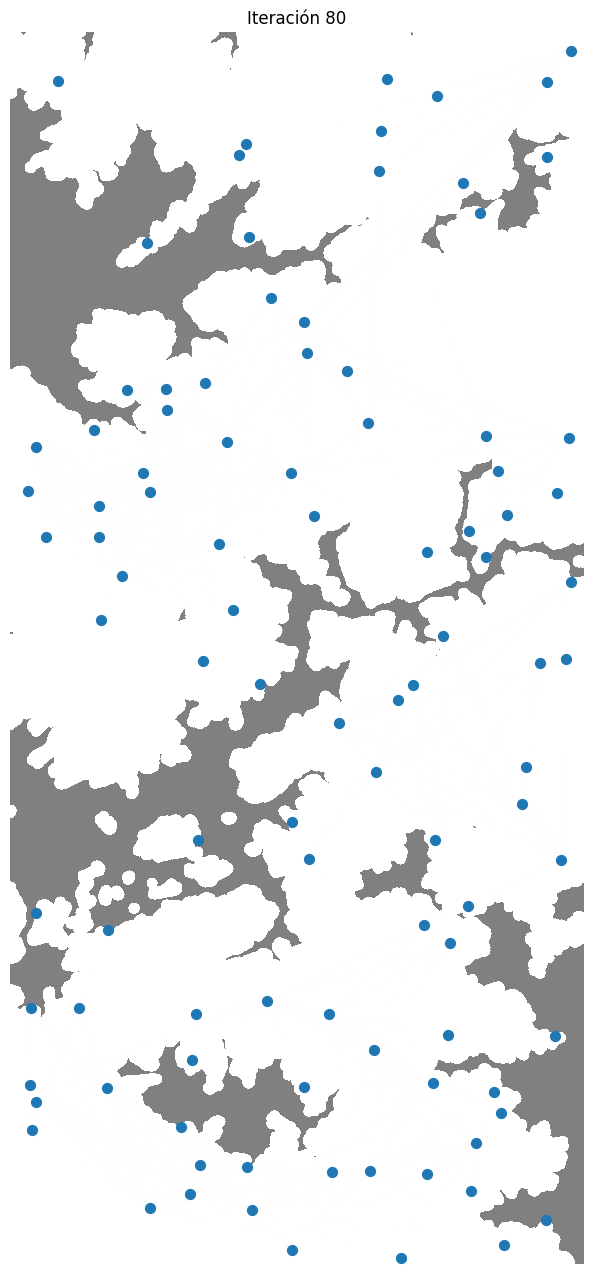

Streaming output truncated to the last 5000 lines.
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602284325e-05
update_conductivities_for
New conductivity4.048376602

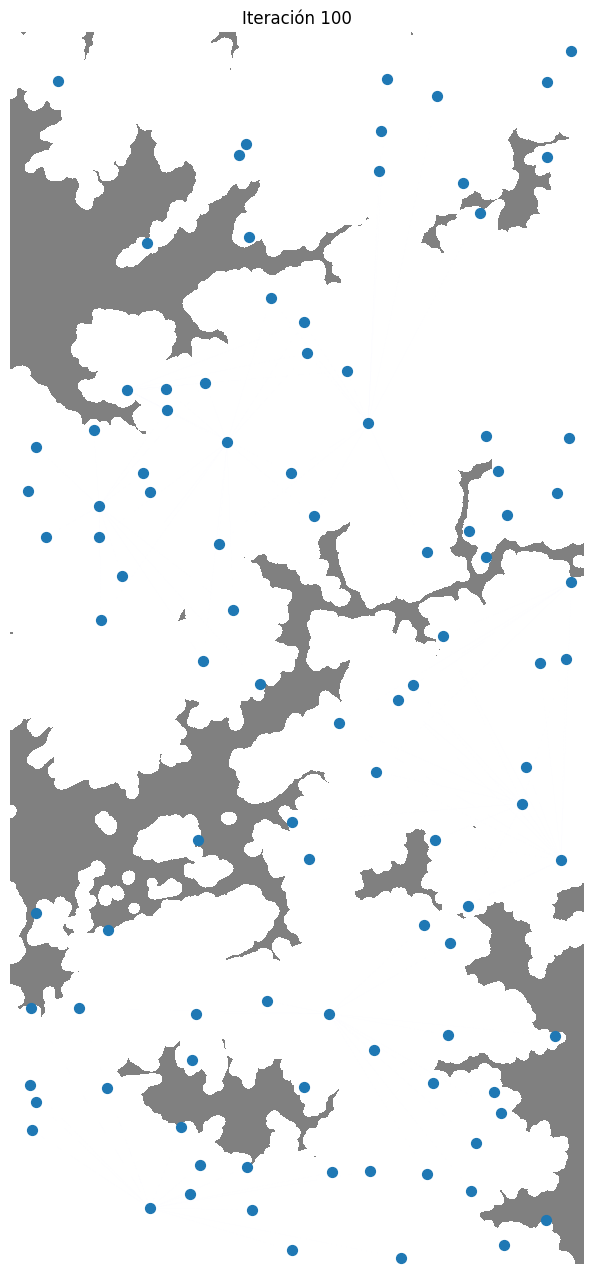

Iteración 100/100 completada.
Simulación completada.


In [113]:
# Parámetros del modelo
I0 = 1.0       # Intensidad del flujo
g = 2.0        # Factor de no linealidad
delta_t = 0.1  # Paso de tiempo
num_iterations = 100  # Número de iteraciones del algoritmo (ajustable)

# Lista para almacenar el historial de conductividades (opcional)
conductivity_history = []
# Iteración del algoritmo
for iteration in range(num_iterations):
    # Seleccionar aleatoriamente el nodo fuente y sumidero
    source_node = random.choice(list(G.nodes()))
    sink_node = random.choice(list(G.nodes()))
    while sink_node == source_node:
        sink_node = random.choice(list(G.nodes()))

    #if not(line_collision_points(boolean_map, source_node, sink_node)):
    # Ajustar las presiones y calcular los flujos
    p, Q = adjust_pressures(G, source_node, sink_node, I0)

    # Actualizar las conductividades
    update_conductivities(G, Q, delta_t, g)

    # Almacenar las conductividades para visualización (cada 10 iteraciones)
    if iteration % 10 == 0:
        D_values = [G.edges[edge]['conductivity'] for edge in G.edges()]
        conductivity_history.append(D_values)

    # Visualizar la red cada 20 iteraciones
    if (iteration + 1) % 20 == 0:
        plt.figure(figsize=(16, 16))
        edge_widths = [G.edges[edge]['conductivity'] * 5 for edge in G.edges()]
        pos = node_positions  # Usar las posiciones aleatorias de los nodos

        # Dibujar los obstáculos
        plt.imshow(boolean_map.T, cmap=cmap_elevation_mask)
        nx.draw(G, pos=pos, node_size=50, width=edge_widths, with_labels=False, edge_color='blue')
        plt.title(f'Iteración {iteration + 1}')
        plt.xlim(0, workspace_latitude)
        plt.ylim(0, workspace_longitude)
        plt.show()

    # Información de progreso (opcional)
    if (iteration + 1) % 50 == 0:
        print(f"Iteración {iteration + 1}/{num_iterations} completada.")

print("Simulación completada.")

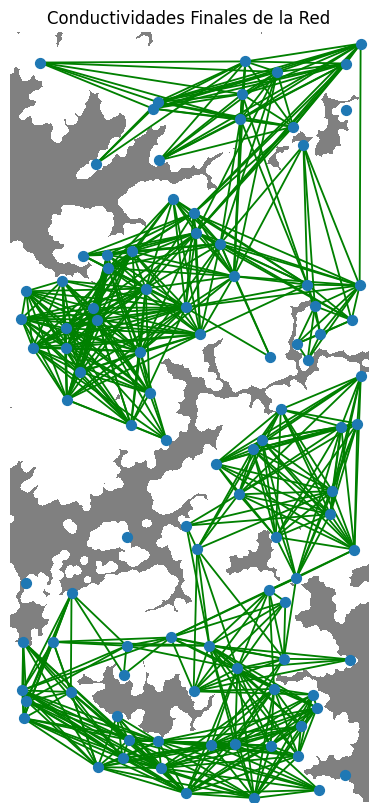

In [114]:
# Visualización de la red final
plt.figure(figsize=(10, 10))

# Obtener las conductividades para ajustar el grosor de los bordes
edge_widths = [G.edges[edge]['conductivity'] * 50000 for edge in G.edges()]  # Multiplicar para mejor visibilidad

# Dibujar los obstáculos
plt.imshow(boolean_map.T, cmap=cmap_elevation_mask)

# Dibujar la red
nx.draw(G, pos=node_positions, node_size=50, width=edge_widths, with_labels=False, edge_color='green')

plt.title('Conductividades Finales de la Red')
plt.xlim(0, workspace_latitude)
plt.ylim(0, workspace_longitude)

plt.show()

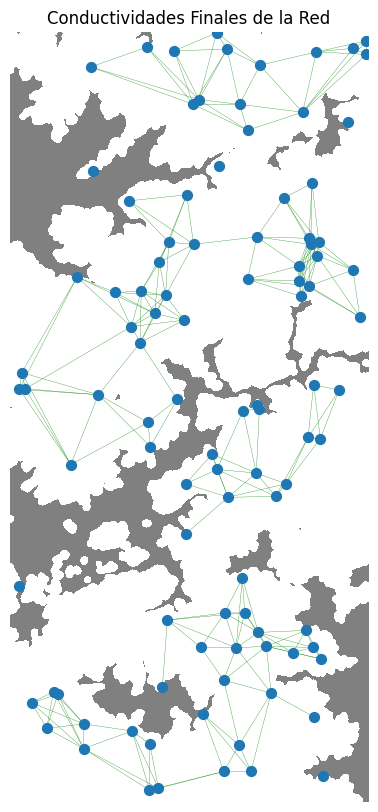

In [157]:
# Visualización de la red final
plt.figure(figsize=(10, 10))

# Obtener las conductividades para ajustar el grosor de los bordes
edge_widths = [G.edges[edge]['conductivity'] * 5000 for edge in G.edges()]  # Multiplicar para mejor visibilidad

# Dibujar los obstáculos
plt.imshow(boolean_map.T, cmap=cmap_elevation_mask)

# Dibujar la red
nx.draw(G, pos=node_positions, node_size=50, width=edge_widths, with_labels=False, edge_color='green')

plt.title('Conductividades Finales de la Red')
plt.xlim(0, workspace_latitude)
plt.ylim(0, workspace_longitude)

plt.show()

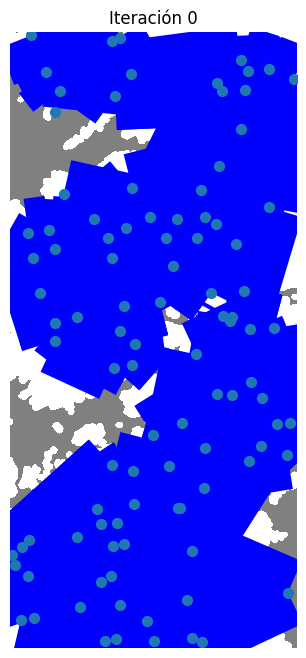

In [85]:
# Crear una figura para la animación
fig, ax = plt.subplots(figsize=(8, 8))

def animate(i):
    ax.clear()
    edge_widths = [conductivity_history[i][idx] * 50 for idx in range(len(G.edges()))]
    current_edges = list(G.edges())

    # Dibujar los obstáculos
    plt.imshow(boolean_map.T, cmap=cmap_elevation_mask)

    nx.draw(G, pos=node_positions, ax=ax, node_size=50, width=edge_widths, with_labels=False, edge_color='blue')

    ax.set_title(f'Iteración {i * 10}')
    plt.xlim(0, workspace_latitude)
    plt.ylim(0, workspace_longitude)
    ax.axis('off')

# Crear la animación (cada cuadro representa cada 10 iteraciones almacenadas)
ani = animation.FuncAnimation(fig, animate, frames=len(conductivity_history), interval=500, repeat=False)

# Mostrar la animación en el notebook
HTML(ani.to_jshtml())